/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-u

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


[*]resizing finish!!
training_data : (10000, 32, 32, 1)
eval_data     : (7, 32, 32, 1)



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'mnist_Autoencoder_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f25130ded30>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:t

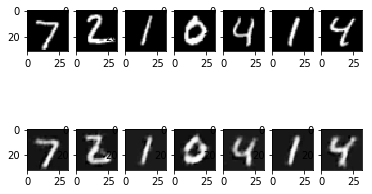

SystemExit: 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform
import tensorflow.contrib.layers as lays
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
%matplotlib inline

def resize_batch(imgs):

    imgs = imgs.reshape((-1, 28, 28, 1))
    resized_imgs = np.zeros((imgs.shape[0], 32, 32, 1))
    for i in range(imgs.shape[0]):
        resized_imgs[i, ..., 0] = transform.resize(imgs[i, ..., 0], (32, 32))

    return resized_imgs

def cnn_model_fn(features, labels, mode):

    net = lays.conv2d(features["x"], 32, [5, 5], stride=2, padding='SAME')
    net = lays.conv2d(net, 16, [5, 5], stride=2, padding='SAME')
    net = lays.conv2d(net, 8, [5, 5], stride=4, padding='SAME')
    net = lays.conv2d_transpose(net, 16, [5, 5], stride=4, padding='SAME')
    net = lays.conv2d_transpose(net, 32, [5, 5], stride=2, padding='SAME')
    logits = lays.conv2d_transpose(net, 1, [5, 5], stride=2, padding='SAME', activation_fn=tf.nn.tanh)

    predictions = {"output":logits}

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss = tf.reduce_mean(tf.square(logits - labels))  # claculate the mean square error loss
    logging_hook = tf.train.LoggingTensorHook({ "global_step":tf.train.get_global_step(),
                                               "loss":loss},
                                              every_n_iter=20)

    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(loss=loss,
                                      global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op,
                                          training_hooks=[logging_hook])

def main(unused_argv):

    training_num=10000
    test_num=7
    num_epochs=10
    mnist = tf.contrib.learn.datasets.load_dataset("mnist")

    print('[*]resizing imgs...') 

    train_data = resize_batch(mnist.train.images[:training_num,:])
    eval_data = resize_batch(mnist.test.images[:test_num,:])

    print('[*]resizing finish!!')
    print('training_data : {}'.format(train_data.shape))
    print('eval_data     : {}'.format(eval_data.shape))
    print('\n\n')
          

    mnist_classifier = tf.estimator.Estimator(
        model_fn=cnn_model_fn, model_dir="mnist_Autoencoder_model")

    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": train_data},
        y=train_data,
        batch_size=200,
        num_epochs=num_epochs,
        shuffle=False)

    mnist_classifier.train(
        input_fn=train_input_fn)

    predict_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": eval_data},
        num_epochs=1,
        shuffle=False)

    eval_results = list(mnist_classifier.predict(input_fn=predict_input_fn))

    idx=1
    for p in eval_results:
        plt.subplot(2,test_num,idx)
        plt.imshow(eval_data[idx-1][:,:,0],cmap='gray')
        plt.subplot(2,test_num,test_num+idx)
        plt.imshow(p["output"][:,:,0], cmap='gray')
        idx+=1
    plt.show()

if __name__ == "__main__":
    tf.app.run()
